In [5]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

In [6]:
x=0.2*librosa.tone(440,sr=44000,length=1024)+0.3*librosa.tone(330,sr=44000,length=1024)
d=0.5*librosa.tone(440,sr=44000,length=1024)

In [7]:
d,sr= librosa.load('../media/nearend_mic_fileid_0.wav')
x,sr=librosa.load('../media/farend_speech_fileid_0.wav')
echo,sr=librosa.load('../media/echo_fileid_0.wav')
near_end,sr= librosa.load('../media/nearend_speech_fileid_0.wav')

In [8]:
def lms(x,d,mu,taps):
    N=len(x)
    w=np.zeros((taps,1))
    e=np.zeros_like(x)
    y=np.zeros_like(x)
    for n in range(0,N-taps):
        xd = np.flipud(x[n:n+taps])  # Slice to get view of M latest datapoints
        y[n] = np.dot(xd,w)
        e[n] = d[n] - y[n]
        F=mu*np.multiply(xd,e[n])
        F=F.reshape(F.shape[0],-1)
        w = w +F
        y[n] = np.dot(xd, w)
    
    return (y,e,w)


In [9]:
class AdaptiveFilters():
    def __init__(self,mu,taps):
        self.e=0
        self.w=np.zeros((taps,1))
        self.xd=np.zeros((taps,1))
        self.mu=mu
        self.N=taps

class LMS(AdaptiveFilters):
    #initialize
    def __init__(self,mu,taps):
        super().__init__(mu,taps)

    #updates the filter sample by sample and updates weights sample by sample
    def run(self,x,d):
        N=self.N
        #udpate delay line 
        self.xd[0]=x
        y = np.dot(self.w.T,self.xd)
        
        e = d - y
        
        Fw=self.mu*np.multiply(self.xd,e)
        
        Fw=Fw.reshape(Fw.shape[0],-1)
        
        self.w = self.w + Fw
    
        y = np.dot(self.w.T,self.xd)
        #shift delay line
        self.xd[1:N-1]=self.xd[0:N-2]
        self.e=e

        return (y,e,w)


class NLMS(AdaptiveFilters):
    #initialize
    def __init__(self,mu,taps):
        super().__init__(mu,taps)

    #updates the filter sample by sample and updates weights sample by sample
    def run(self,x,d):
        N=self.N
        #udpate delay line 
        self.xd[0]=x
        #compute filter output
        y = np.dot(self.w.T,self.xd)
        #compute input energy
        pw=np.linalg.norm(self.xd)
        #calculate error
        e = d - y
        #normalize by input energy
        e= e/(pw+0.0000001)
        #compute gradients
        Fw=self.mu*np.multiply(self.xd,e)
        
        Fw=Fw.reshape(Fw.shape[0],-1)
        #weight update
        self.w = self.w + Fw
    
        #filtered output post update
        y = np.dot(self.w.T,self.xd)
        #shift delay line
        self.xd[1:N-1]=self.xd[0:N-2]
        self.e=e

        #return current output sample, current error sample and current weights
        return (y,e,w)


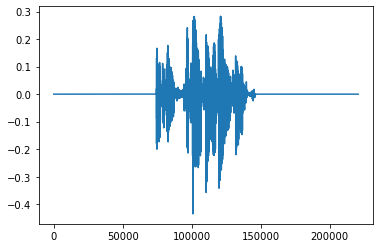

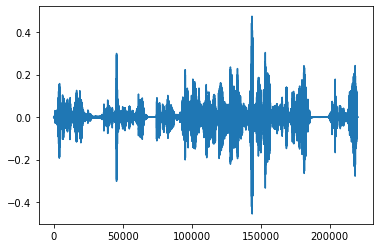

In [10]:
(y,e,w)= lms(x,d,0.1,1024)
plt.figure()
plt.plot(near_end)
plt.figure()
plt.plot(e)
#plt.plot(d)

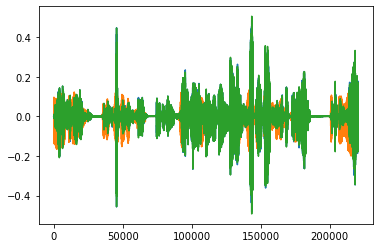

In [11]:
#test wrapper for LMS filter
lmscls= LMS(0.01,256)

y=np.zeros_like(x)
e=np.zeros_like(x)
for i in range(0,len(x)):
    (y[i],e[i],w)=lmscls.run(x[i],d[i])

plt.plot(e)
plt.plot(x)
plt.plot(d)

Text(0.5, 1.0, 'far end reference(input signal)')

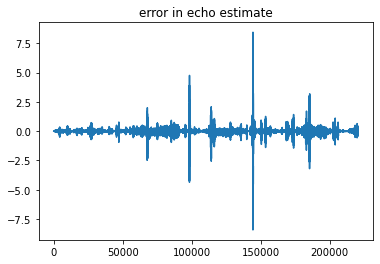

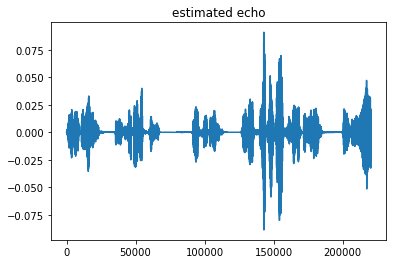

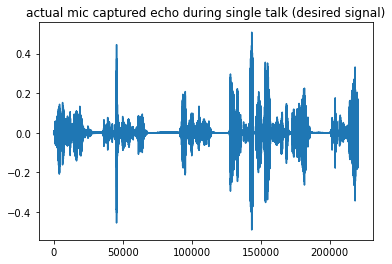

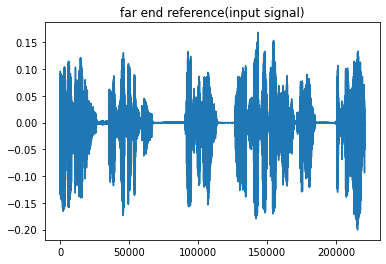

In [14]:
#test wrapper for NLMS filter on aec data for single talk case
taps=512
lmscls= NLMS(0.05,taps)
w=np.zeros((taps,1))
y=np.zeros_like(x)
e=np.zeros_like(x)
for i in range(0,len(x)):
    (y[i],e[i],w)=lmscls.run(x[i],echo[i])

plt.figure()
plt.plot(e)
plt.title("error in echo estimate")
plt.figure()
plt.plot(y)
plt.title("estimated echo")
plt.figure()
plt.plot(echo)
plt.title("actual mic captured echo during single talk (desired signal)")
plt.figure()
plt.plot(x)
plt.title("far end reference(input signal)")